In [71]:
import torch as to
import os
from tensorboardX import SummaryWriter
import time
import pandas as pd
import datetime
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
import bayes_opt
import gc
import random
%matplotlib inline  

In [3]:
dataset_dir = '/home/ubuntu/ihor/'

In [4]:
measurements_dataset_path = os.path.join(dataset_dir, 'measurements.csv')

In [108]:
measurements_dataset = pd.read_csv(measurements_dataset_path, nrows=500)

In [109]:
measurements_dataset['cap_time_timestamp'] = pd.to_datetime(measurements_dataset['Captured Time'], format="%Y-%m-%d %H:%M:%S")

In [110]:
cleared_measurements_dataset = measurements_dataset[pd.isnull(measurements_dataset['cap_time_timestamp']) == False].sort_values(by='cap_time_timestamp')

In [111]:
cleared_measurements_dataset['y'] = range(len(cleared_measurements_dataset))

In [112]:
from torch.utils import data
from torch.utils.data import Dataset
from torch.autograd import Variable

class NumericalDataset(Dataset):
    def __init__(self, values, labels):
        self.values = values
        self.labels = labels

    def __len__(self):
        return len(self.values)

    def __getitem__(self, num):
        x = to.Tensor([self.values[num]])
        y = self.labels[num]
        sample = {'x': x, 'y': y}

        return sample

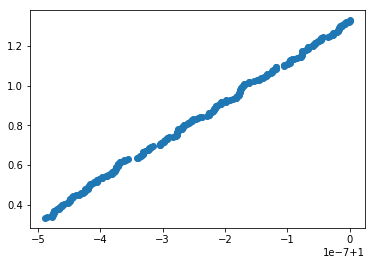

In [113]:
xs = np.array(cleared_measurements_dataset['cap_time_timestamp'].map(pd.Timestamp.timestamp).map(float))[100:-100]
ys = np.array(cleared_measurements_dataset['y'])[100:-100]

xs = xs / max(xs)
ys = ys / len(ys)

plt.plot(xs, ys, 'o')
plt.show()

shuffled = list(range(len(ys)))
random.shuffle(shuffled)

In [114]:
activations = [to.nn.ReLU, to.nn.LeakyReLU, to.nn.ELU, to.nn.Sigmoid, to.nn.PReLU]

In [115]:
def optimize(hidden_size, batch_size, activation_idx, dropout_prob, layers_num, weight_decay, learning_rate):
    input_size = 1
    out_size = 1
    hidden_size = int(np.round(hidden_size))
    batch_size = int(np.round(batch_size))
    activation = activations[int(np.round(activation_idx))]
    layers_num = int(np.round(layers_num))
    args = inspect.getargvalues(inspect.currentframe()).args
    lcls = locals()
    logs_name = '__'.join([f'{i}_{lcls[i]}' for i in lcls if i in args])
    
    epochs = 50

#     model_backbone = [(to.nn.Linear(input_size, hidden_size), activation(), to.nn.Dropout(dropout_prob))]
    
#     model_backbone += [(
#         to.nn.Linear(hidden_size, hidden_size),
#         activation(),
#         to.nn.Dropout(dropout_prob)
#     ) for i in range(layers_num)]
    
#     model_backbone += [(to.nn.Linear(hidden_size, out_size),)]
    
#     model_sequence = [j for i in model_backbone for j in i]
    
    model = to.nn.Sequential(*model_sequence)
    summary_writer = SummaryWriter(log_dir=os.path.join('./logs_bo', logs_name, str(int(time.time()))))

    train_dataset = NumericalDataset(xs[shuffled], ys[shuffled])
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    train_total_batches = np.ceil(len(train_dataset) / float(batch_size))

    def cuda(x):
        return x.cuda()

    loss_fn = to.nn.MSELoss()
    optimizer = to.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)

    cuda(model)
    
#     print(model)
    
    for epoch in range(epochs):
#         print(f'epoch {epoch}/{epochs}')
        model.train(True)
        loss_aggregator = 0
        for i, batch in enumerate(train_loader):
            x = Variable(cuda(batch['x']))
            y = Variable(cuda(batch['y'].type(to.FloatTensor).view(-1, 1)))
            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            loss_aggregator += loss.data[0]

            if i % 10 == 0:
                loss_aggregator /= 10
                summary_writer.add_scalar(f'train mse loss', loss_aggregator, epoch * train_total_batches + i)
                loss_aggregator = 0

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    model.train(False)
    
    result =loss_fn(
        model(cuda(to.Tensor([xs]).view(-1, 1))),
        cuda(to.Tensor([ys]).type(to.FloatTensor).view(-1, 1))
    )
    
    del model
    
    gc.collect()
    
    return -result

In [101]:
# optimize(hidden_size=5, batch_size=32, activation_idx=2, dropout_prob=0.6, layers_num=2, weight_decay=1e-5, learning_rate=1e-4)

In [116]:
bo = bayes_opt.BayesianOptimization(optimize, {
    'hidden_size':(5, 64),
    'batch_size':(4,32),
    'activation_idx':(0,4),
    'dropout_prob':(0.3,0.7),
    'layers_num': (1,4),
    'weight_decay':(1e-5, 1e-4),
    'learning_rate': (1e-5, 1e-2)
})

In [117]:
bo.maximize(n_iter=150)

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   activation_idx |   batch_size |   dropout_prob |   hidden_size |   layers_num |   learning_rate |   weight_decay | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


    1 | 00m01s |   -0.08391 |           1.3858 |      16.7092 |         0.3595 |       41.0283 |       1.2246 |          0.0098 |         0.0001 | 
    2 | 00m01s |   -0.08333 |           0.7740 |      21.5369 |         0.3570 |       44.5174 |       3.8692 |          0.0041 |         0.0000 | 
    3 | 00m01s |   -0.08700 |           3.2584 |      16.7732 |         0.3538 |       40.5234 |       1.0053 |          0.0025 |         0.0001 | 
    4 | 00m01s |   -0.08336 |           0.2400 |      18.0678 |         0.5430 |        7.5102 |       2.5945 |          0.0046 |         0.0000 | 
    5 | 00m01s |   -0.08411 |           0.6651 |      31.2088 |         0.5409 |       63.3885 |       2.1789 |          0.0037 |         0.0001 | 
Bayesian Optimization
--------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   activation_idx |   batch_size |   dropout_prob |   hidden_s

/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.63925911e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


    7 | 00m19s |   -0.08468 |           0.0511 |      31.9881 |         0.4607 |       13.9526 |       1.2129 |          0.0014 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.02844789e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


    8 | 00m25s |   -0.08397 |           0.0301 |       4.0352 |         0.3079 |       17.8128 |       2.3774 |          0.0041 |         0.0000 | 
    9 | 00m19s |   -0.08336 |           0.0403 |      24.1692 |         0.6812 |       38.3108 |       1.1106 |          0.0049 |         0.0001 | 
   10 | 00m20s |   -0.08334 |           0.0929 |      16.0192 |         0.3248 |        5.6366 |       1.0422 |          0.0018 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.96628941e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00012074]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00048183]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   11 | 00m20s |   -0.08338 |           0.0804 |      19.2747 |         0.3030 |       21.2263 |       2.8495 |          0.0052 |         0.0000 | 
   12 | 00m20s |   -0.08333 |           0.4036 |      28.3328 |         0.3004 |        5.1783 |       3.9271 |          0.0039 |         0.0000 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.25775506e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   13 | 00m24s |   -0.08549 |           0.0290 |       5.0546 |         0.5823 |       37.2206 |       3.9890 |          0.0095 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.41337711e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


   14 | 00m19s |   -0.09179 |           0.0216 |      23.7766 |         0.3490 |       57.7819 |       1.1269 |          0.0001 |         0.0001 | 
   15 | 00m29s |   -0.08472 |           3.3269 |       4.0525 |         0.3246 |        5.0242 |       3.7414 |          0.0090 |         0.0001 | 
   16 | 00m21s |   -0.08333 |           3.9441 |      31.6976 |         0.6301 |        5.9939 |       1.6017 |          0.0070 |         0.0000 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00015238]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   21 | 00m29s |   -0.08339 |           0.0890 |      31.9548 |         0.3426 |       48.1269 |       3.4324 |          0.0077 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([4.1718029e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   22 | 00m29s |   -0.08350 |           0.3016 |      31.8756 |         0.5618 |       32.8976 |       3.9106 |          0.0022 |         0.0000 | 
   23 | 00m32s |   -0.08481 |           0.0089 |       4.6435 |         0.3403 |       48.4794 |       1.0281 |          0.0095 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00089538]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00015101]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   24 | 00m28s |   -0.08336 |           3.7488 |      29.8717 |         0.3024 |       10.4751 |       3.8721 |          0.0014 |         0.0000 | 
   25 | 00m29s |   -0.08337 |           0.0011 |      18.4896 |         0.6918 |       34.3461 |       3.7013 |          0.0064 |         0.0000 | 
   26 | 00m26s |   -0.08413 |           3.6419 |      31.8124 |         0.3450 |       41.3347 |       1.1733 |          0.0045 |         0.0000 | 
   27 | 00m29s |   -0.08337 |           0.1980 |      10.7542 |         0.3107 |       12.2590 |       3.9711 |          0.0027 |         0.0000 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00064454]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   28 | 00m27s |   -0.08462 |           3.9952 |      31.7402 |         0.3272 |       63.4293 |       1.0526 |          0.0079 |         0.0000 | 
   29 | 00m30s |   -0.08343 |           0.0030 |      13.3634 |         0.6912 |       47.7475 |       3.9008 |          0.0097 |         0.0001 | 
   30 | 00m29s |   -0.08339 |           3.4149 |      19.4848 |         0.3327 |        5.0517 |       3.9600 |          0.0093 |         0.0000 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00020133]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   31 | 00m29s |   -0.08384 |           0.2296 |      11.4269 |         0.6917 |       16.6361 |       1.0648 |          0.0073 |         0.0000 | 
   32 | 00m29s |   -0.08334 |           3.2904 |      31.7404 |         0.5784 |        5.1182 |       3.9796 |          0.0094 |         0.0000 | 
   33 | 05m19s |   -0.08334 |           0.0085 |      15.7257 |         0.3040 |       42.6731 |       3.6113 |          0.0039 |         0.0001 | 
   34 | 05m46s |   -0.08337 |           3.5878 |      31.7225 |         0.5820 |       44.5589 |       3.9284 |          0.0097 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0012583]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   35 | 06m17s |   -0.08378 |           0.0328 |       6.2484 |         0.6100 |       29.8797 |       1.0018 |          0.0096 |         0.0001 | 
   36 | 06m29s |   -0.08341 |           0.7694 |      31.9684 |         0.6901 |       63.8234 |       3.6672 |          0.0070 |         0.0000 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00027517]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


   37 | 06m50s |   -0.08440 |           0.0382 |       4.0351 |         0.3108 |       53.2996 |       3.9954 |          0.0021 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00134232]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   38 | 06m25s |   -0.08335 |           0.0802 |       9.8770 |         0.6917 |       24.9962 |       3.9894 |          0.0020 |         0.0001 | 
   39 | 06m18s |   -0.08335 |           2.5852 |      31.9743 |         0.3238 |       55.8228 |       1.4399 |          0.0034 |         0.0001 | 
   40 | 06m06s |   -0.08340 |           1.8409 |      31.9795 |         0.3011 |       29.3301 |       1.0076 |          0.0058 |         0.0000 | 
   41 | 06m28s |   -0.08333 |           1.0991 |      11.4935 |         0.6944 |        5.2222 |       3.9901 |          0.0055 |         0.0000 | 
   42 | 07m12s |   -0.08333 |           0.0052 |      16.7812 |         0.5257 |       30.0358 |       1.1017 |          0.0084 |         0.0000 | 
   43 | 06m43s |   -0.08344 |           3.5614 |      31.7969 |         0.3254 |       35.2229 |       3.9629 |          0.0069 |         0.0001 | 


/home/ubuntu/.pyenv/versions/3.6.1/envs/ihor/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.6228681e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


KeyboardInterrupt: 

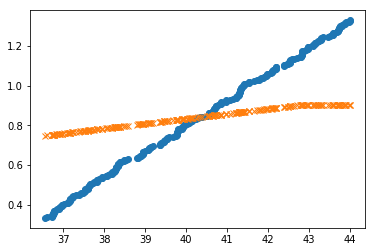

In [349]:
# plt.plot(xsn, ys, 'o')
# plt.plot(xsn, model(cuda(to.Tensor([xsn / 10]).view(-1, 1))).cpu().detach().numpy(), 'x')
# plt.show()